# KEGG Drug database preprocessing from flat file
MI-MVI  
Jiří Reiniš  
reinijir@fit.cvut.cz

In [8]:
import pandas as pd
import numpy as np
import re
import os

import matplotlib as plt

from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger              

import molvs

## Load KEGG DRUG database flat file

In [4]:
# load records into a list
with open("data/kegg_drug", mode='r') as f:
    data = [x.split("\n") for x in f.read().split("///")]
    
for i in range(len(data)):
    data[i] = [x for x in data[i] if x]
data = [x for x in data if x]

In [5]:
display(data[56][:30])

['ENTRY       D00058                      Drug',
 'NAME        gamma-Aminobutyric acid (JAN);',
 '            Gammalon (TN)',
 'FORMULA     C4H9NO2',
 'EXACT_MASS  103.0633',
 'MOL_WEIGHT  103.1198',
 'CLASS       Neuropsychiatric agent',
 '             DG01567  GABA-A receptor agonist',
 '             DG02037  GABA mimetic antiepileptics',
 '             DG01565  GABA-B receptor agonist',
 '            Other',
 '             DG01672  Amino acid',
 'REMARK      Same as: C00334',
 '            Therapeutic category: 2190',
 '            ATC code: N03AG03',
 '            Product: D00058<JP>',
 'EFFICACY    Brain metabolism enhancer, Neurotransmitter',
 'COMMENT     Fatty acid derivative',
 'TARGET      GABR [HSA:2554 2555 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567 2568 55879] [KO:K05175 K05181 K05184 K05185 K05186 K05189 K05192]',
 '            GABBR [HSA:2550 9568] [KO:K04615]',
 'INTERACTION  ',
 'DBLINKS     CAS: 56-12-2',
 '            PubChem: 7847126',
 '           

## Get KEGG_IDs and molecule name for entries included in benchmark dataset

In [4]:
# convert data into a dictionary with IDs as keys
data_parsed = dict()
for x in data:
    data_parsed[x[0].split()[1]] = x

In [5]:
# get list of IDs from benchmark dataset
with open("data/benchmark_dataset_ID_list_sorted", mode='r') as f:
    IDs = [x for x in f.read().split("\n")]
    
display(IDs[:6])
display(len(IDs))

['D00002', 'D00003', 'D00004', 'D00006', 'D00008', 'D00009']

3883

In [6]:
# get benchmark data
data_parsed_filtered = {ID: data_parsed[ID] for ID in IDs if ID in data_parsed.keys()}

# some records are not in the flat file, we'll just leave them out
print(len(data_parsed_filtered), len(IDs))
print([ID for ID in IDs if ID not in data_parsed.keys()])

3875 3883
['D06425', 'D06488', 'D06526', 'D06527', 'D06535', 'D06536', 'D06537', '']


In [7]:
# get a list of pubchem SIDs

benchmark_KEGG_IDs = []
benchmark_PubChem_IDs = []
benchmark_names = []

for ID in sorted(data_parsed_filtered.keys()):
    for i in range(len(data_parsed_filtered[ID])):
        if "NAME" in data_parsed_filtered[ID][i]:
            name = " ".join(data_parsed_filtered[ID][i].split()[1:]).rstrip(";")
            name = re.sub(r'\(.+\)', '', name)
        if "PubChem" in data_parsed_filtered[ID][i]:
            PubChem_ID = data_parsed_filtered[ID][i].split()[-1]
            
            benchmark_KEGG_IDs.append(ID)
            benchmark_PubChem_IDs.append(PubChem_ID)
            benchmark_names.append(name)
            break

In [8]:
len(benchmark_names)

3875

In [9]:
df = pd.DataFrame(benchmark_KEGG_IDs)
df[2] = benchmark_PubChem_IDs
df[3] = benchmark_names
df.columns=["KEGG_ID", "PubChem_SID", "primary_name"]

df

KEGG_ID PubChem_SID                   primary_name
0     D00002     7847070                        Nadide 
1     D00003     7847071                        Oxygen 
2     D00004     7847072                Carbon dioxide 
3     D00006     7847074   Pyridoxal phosphate hydrate 
4     D00008     7847076             Hydrogen peroxide 
...      ...         ...                            ...
3870  D09654   124490394          Pixantrone dimaleate 
3871  D09687   124490427            Ulipristal acetate 
3872  D09724   124490464                      Afatinib 
3873  D09733   124490473            Afatinib dimaleate 
3874  D09739   124490479  Bismuth subcitrate potassium 

[3875 rows x 3 columns]

## Merge with CIDs retrieved from KEGG IDs on PubChem
CIDs are needed to get SMILES from PubChem database. KEGG unfortunately does not provide SMILES.

### Preprocess CID table

In [10]:
CIDs = pd.read_csv("data/benchmark_dataset_CIDs_lookup.txt",
                   sep="\t",
                   header=None, dtype= {1: 'object'})
CIDs.columns = ["KEGG_ID", "PubChem_CID"]
CIDs.tail()

KEGG_ID PubChem_CID
3877  D03263         NaN
3878  D05189         NaN
3879  D06049         NaN
3880  D06178         NaN
3881  D06179         NaN

In [11]:
df = df.merge(CIDs, on='KEGG_ID')
df.head()

KEGG_ID PubChem_SID                  primary_name PubChem_CID
0  D00002     7847070                       Nadide         5893
1  D00003     7847071                       Oxygen          977
2  D00004     7847072               Carbon dioxide          280
3  D00006     7847074  Pyridoxal phosphate hydrate        38882
4  D00008     7847076            Hydrogen peroxide          784

## Get class label info

In [12]:
# load records into a list
with open("data/benchmark_dataset_supplinf", mode='r') as f:
    data = [x.split("\n") for x in f.read().split("(")]
for i in range(len(data)):
    data[i] = [y.lstrip(" ") for y in data[i] if y]
del data[0]

In [13]:
# create a pandas dataframe row for each record

IDs = []
drug_classes = []

for x in data:
    drug_class = re.sub(r'^[0-9]+\)', '', x[0]).split()[0].rstrip(" :")
    for y in x[1:]:
        IDs.append(y)
        drug_classes.append(drug_class)

classes = pd.DataFrame(IDs)
classes[2] = drug_classes
classes.columns=["KEGG_ID", "ATC_class"]

In [14]:
classes.head()

KEGG_ID ATC_class
0  D00002        S1
1  D00006        S1
2  D00008        S1
3  D00015        S1
4  D00018        S1

### Merge with classes info

In [15]:
classes = classes.merge(df, on='KEGG_ID')
classes.head()
classes = classes[['KEGG_ID', 'ATC_class', 'primary_name', 'PubChem_SID',  'PubChem_CID']]

In [16]:
classes.head()

KEGG_ID ATC_class                  primary_name PubChem_SID PubChem_CID
0  D00002        S1                       Nadide      7847070        5893
1  D00006        S1  Pyridoxal phosphate hydrate      7847074       38882
2  D00008        S1            Hydrogen peroxide      7847076         784
3  D00008        S4            Hydrogen peroxide      7847076         784
4  D00008       S13            Hydrogen peroxide      7847076         784

#### Remove entries without CIDs

In [17]:
classes = classes[classes.PubChem_CID.notnull()]
classes

KEGG_ID ATC_class                  primary_name PubChem_SID PubChem_CID
0     D00002        S1                       Nadide      7847070        5893
1     D00006        S1  Pyridoxal phosphate hydrate      7847074       38882
2     D00008        S1            Hydrogen peroxide      7847076         784
3     D00008        S4            Hydrogen peroxide      7847076         784
4     D00008       S13            Hydrogen peroxide      7847076         784
...      ...       ...                           ...         ...         ...
4882  D08262       S14                 Mangafodipir     96024950    46174095
4883  D08504       S14                     Samarium     96025189      164133
4884  D08512       S14                    Sevelamer     96025197     3085017
4885  D08548       S14         Sulphobromophthalein     96025233        5345
4886  D09213       S14             Methiodal sodium     96025893    23662381

[4784 rows x 5 columns]

## Merge with SMILES downloaded from PubChem

In [18]:
SMILES = pd.read_csv("data/benchmark_dataset_SMILES.csv", quoting=True, sep=",", dtype= {0: 'object'})

In [19]:
SMILES.head()

PubChem_CID MolecularFormula  MolecularWeight  \
0        5893   C21H28N7O14P2+          664.400   
1       38882        C8H12NO7P          265.160   
2         784             H2O2           34.015   
3        5961        C5H10N2O3          146.140   
4    54670067           C6H8O6          176.120   

                                     CanonicalSMILES  
0  C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...  
1                  CC1=NC=C(C(=C1O)C=O)COP(=O)(O)O.O  
2                                                 OO  
3                               C(CC(=O)N)C(C(=O)O)N  
4                         C(C(C1C(=C(C(=O)O1)O)O)O)O

In [20]:
final_df = classes.merge(SMILES, on='PubChem_CID')

In [21]:
final_df[["KEGG_ID", "ATC_class", "primary_name", "PubChem_CID", "CanonicalSMILES"]].sample(n = 10)

KEGG_ID ATC_class                primary_name PubChem_CID  \
3428  D00329       S10                 Flurazepam         3393   
291   D01082        S4       Calcium pantothenate       443753   
3757  D02627       S10                 Benperidol        16363   
1967  D02184        S4      Erythromycin stearate        12559   
4258  D01021       S13        Naphazoline nitrate        82332   
3437  D00376       S10                Meprobamate         4064   
1219  D00614        S3       Sodium nitroprusside     11953895   
279   D00996        S1  Epinephrine hydrochloride       441411   
1445  D03991        S3    Encainide hydrochloride        48040   
3438  D00387       S10                  Triazolam         5556   

                                        CanonicalSMILES  
3428  CCN(CC)CCN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC...  
291   CC(C)(CO)C(C(=O)NCCC(=O)[O-])O.CC(C)(CO)C(C(=O...  
3757  C1CN(CCC1N2C3=CC=CC=C3NC2=O)CCCC(=O)C4=CC=C(C=...  
1967  CCCCCCCCCCCCCCCCCC(=O)O.CCC1C(C(C(C(=O)C(CC(C(...  
4258     C1CN=C(N1)CC2=CC=CC3=CC=CC=C32.[N+](=O)(O)[O-]  
3437                          CCCC(C)(COC(=O)N)COC(=O)N  
1219  [C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[N-]=O.O.O....  
279                         CNCC(C1=CC(=C(C=C1)O)O)O.Cl  
1445     CN1CCCCC1CCC2=CC=CC=C2NC(=O)C3=CC=C(C=C3)OC.Cl  
3438   CC1=NN=C2N1C3=C(C=C(C=C3)Cl)C(=NC2)C4=CC=CC=C4Cl

In [22]:
RDLogger.DisableLog('rdApp.*') 
final_df["Molecule"] = [Chem.MolFromSmiles(mol) for mol in final_df["CanonicalSMILES"]]

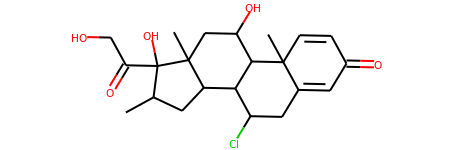

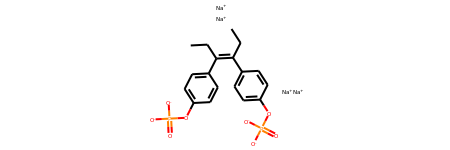

In [39]:
for x in final_df.sample(n = 4)["Molecule"]:
    display(x)

## Standardization of molecules (optional, not used at the moment)

#### Keep only molecules that have passed standardization procedure

## Generate Molecular Fingerprints

In [23]:
final_df['FP2'] = [np.asarray(Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)) for mol in final_df['Molecule']]

## Example of preprocessed record: SMILES, fingerprint, image

'Scopolamine '

'CN1C2CC(CC1C3C2O3)OC(=O)C(CO)C4=CC=CC=C4'

'010000000000000000000000000000000100000001000000000000000000000010000000000000001000000000000000000000100000000000000001010000000000000000000000000100000000000000010000000000010000000000000000000000000000000000000000000001100000000000000000000000000000000000000000000010000000001000000000000000000000000000000000000000000000000000000000000001000000000000001000000000000000000000001100000001000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000100000000000000000000000000000000000000000000000000000000000001000000100000000000000000000000000000000000010000000000000000000000000000000000000000000000001000001010000001000000000000000000000000000001000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000001000100000000000000000000000000000000000000000100000000000000000000000000000000000000000001000100000000000000000000000000001000000001000000000000000000000000000000000000000000000000000000000000000

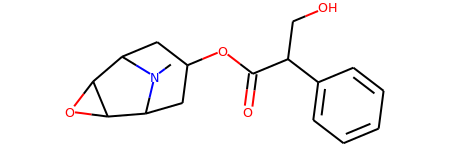

In [24]:
mol = final_df.iloc[42]
display(mol.primary_name)
display(mol.CanonicalSMILES)
display("".join([str(x) for x in mol.FP2]))
display(mol.Molecule)

## Export as PNG image

In [11]:
# note to self: target directory must already exist
PNG_path = 'data/PNG_small/'
size = 128

In [12]:
os.system('mkdir -p ' + PNG_path)

for index, row in final_df[["KEGG_ID", "Molecule", "ATC_class"]].iterrows():
    Chem.Draw.MolToFile(row[1], size=(size,size), fileName = "{}{}.png".format(PNG_path, row[0]))

## Export dataset as pickle

In [56]:
final_df.to_pickle("data/dataset_master_pickled")

# Reload if needed

In [6]:
final_df = pd.read_pickle("data/dataset_master_pickled")